In [1]:
import pickle

import sys
sys.path.append('/home/akashm/PROJECT/Hiwi_qml/qcbm/model_local_no_pretraining/')
from model_and_circuit_copy import *

from jax.lib import xla_bridge
jax.experimental.enable_x64()
print("JAX Backend:", xla_bridge.get_backend().platform)

JAX Backend: gpu


In [2]:
# Saving the AntiCat distribution
with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/cat_anticat/4qubit_anticat_distribution.pkl',"rb") as file2:
    anticat_data = pickle.load(file2)

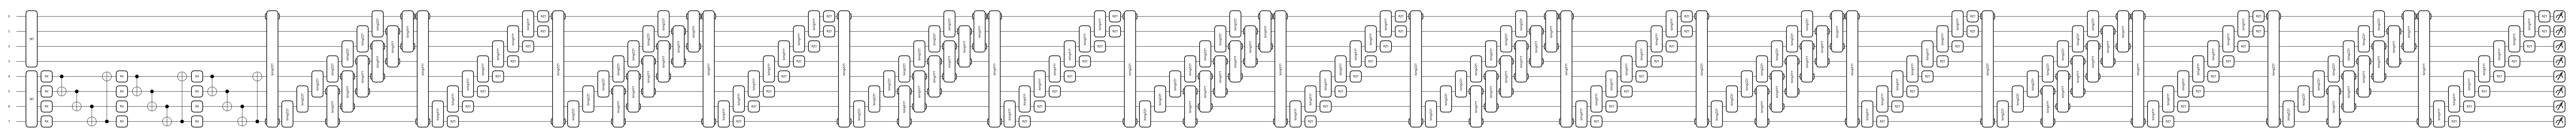

In [3]:
qml.draw_mpl(circuit,device='default')(input_params=initial_params)
plt.show()

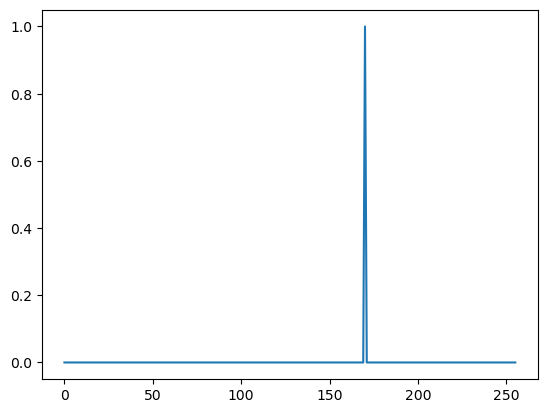

In [4]:
import numpy as np

# Target binary pattern
target_binary = "10101010"
# Convert binary to decimal index
target_index = int(target_binary, 2)

# Create a one-hot encoded target distribution
num_qubits = 8
target_distribution = np.zeros(2**num_qubits)
target_distribution[target_index] = 1

plt.plot(target_distribution)

In [5]:
class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy)
    
class QCBM:
    def __init__(self,circ,mmd,py):
        self.circ = circ
        self.mmd = mmd
        self.py = py
    
    def mmd_loss(self,params):
        px = self.circ(params)
        return self.mmd(px,self.py), px
    

#Model Training
@jit
def update_step(params,opt_state):
    
    (loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)

    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    qcbm_probs = jnp.asarray(qcbm_probs, dtype=jnp.float64)
    
    kl_div = -jnp.sum(target_distribution * jnp.nan_to_num(jnp.log(qcbm_probs) - jnp.log(target_distribution)))
    
    return params, opt_state, loss_val, kl_div


In [6]:
#Calling MMD class
bandwidth = jnp.array([0.25,60],dtype=jnp.float64)
space = jnp.arange(0,2**total_qubits,dtype=jnp.float64)
mmd = MMD(bandwidth,space=space)


#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd=mmd,py=target_distribution)


#Initial parameters
weights = initial_params
lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.99,transition_begin=300,end_value=0.025,staircase=True)
# lr = 0.025
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(weights)


history = []
divs = []
parameters = []


kl_div = 1
i = 0 
# i = start_epoch

# while kl_div > 10^-3:
while i < 5001:
    i+=1
    current_lr = lr(i)
    # current_lr = lr
    start_time = time.time()
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    end_time = time.time()
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div} current_lr:{current_lr} Time taken per iteration: {end_time-start_time}")
    
    history.append(loss_val)
    divs.append(kl_div)
    parameters.append(weights)
    

Step: 10 Loss: 0.3737805485725403 KL_div:1.6188695430755615 current_lr:0.10000000149011612 Time taken per iteration: 0.02735447883605957
Step: 20 Loss: 0.288358211517334 KL_div:1.2636535167694092 current_lr:0.10000000149011612 Time taken per iteration: 0.011274099349975586
Step: 30 Loss: 0.25972050428390503 KL_div:1.1571805477142334 current_lr:0.10000000149011612 Time taken per iteration: 0.00640106201171875
Step: 40 Loss: 0.2335512340068817 KL_div:1.0596600770950317 current_lr:0.10000000149011612 Time taken per iteration: 0.007769346237182617
Step: 50 Loss: 0.2216077744960785 KL_div:1.023871660232544 current_lr:0.10000000149011612 Time taken per iteration: 0.012688398361206055
Step: 60 Loss: 0.2178303599357605 KL_div:1.015674114227295 current_lr:0.10000000149011612 Time taken per iteration: 0.008831501007080078
Step: 70 Loss: 0.21566760540008545 KL_div:1.0105302333831787 current_lr:0.10000000149011612 Time taken per iteration: 0.013044357299804688
Step: 80 Loss: 0.21422243118286133 KL

<BarContainer object of 5 artists>

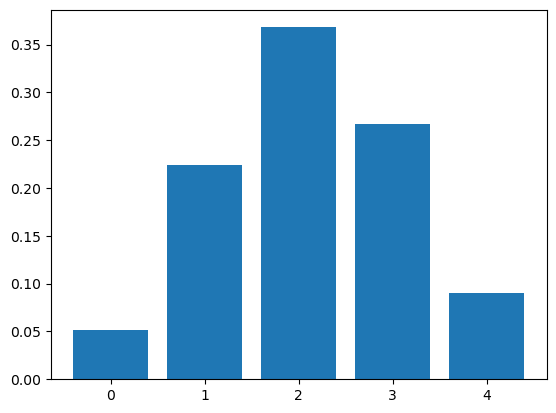

In [20]:
#Particle number distribution
def pnumber_distribution(distribution, n_qubits):
    p_distribution = jnp.zeros(n_qubits+1,dtype=jnp.float64)
    for i in range(2**n_qubits):
        binary_string = format(i,f'0{n_qubits}b')
        num_of_ones = binary_string.count('1')
        p_distribution = p_distribution.at[num_of_ones].add(distribution[i])
    #Normalize the distribution
    p_distribution/=p_distribution.sum()
    return p_distribution

x = np.arange(0,5)
plt.bar(x,pnumber_distribution(cat_data,4))

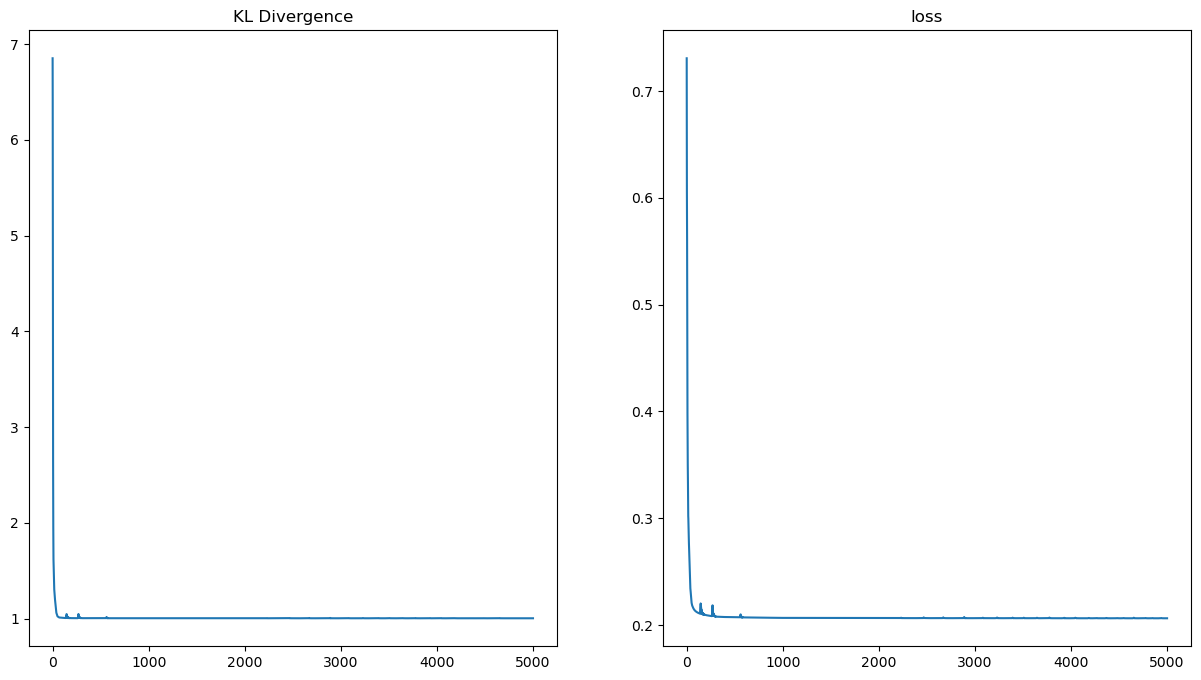

In [21]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(divs)
axs[0].title.set_text('KL Divergence')

axs[1].plot(history)
axs[1].title.set_text('loss')

<BarContainer object of 256 artists>

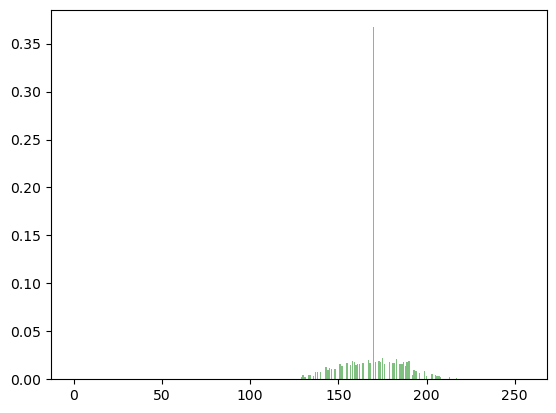

In [22]:
optimal_params = parameters[np.argmin(divs)]

qcbm_probs = circuit(optimal_params)
x_array = jnp.arange(0,2**(total_qubits),dtype=jnp.float64)


plt.bar(x_array,qcbm_probs,color='green',alpha=0.5,label='Obtained Cat')
# plt.plot(x_array,target_distribution,color='blue',alpha=0.5,label='Original Cat')
# axs[0].title.set_text('Target Distribution')

In [23]:
print(f"Minimum KL Divergence obtained is {np.min(divs)}")

Minimum KL Divergence obtained is 1.0023400783538818


In [ ]:
#Save Checkpoint
checkpoint = {"final_epoch":i,
              "history":history,
              "divs":divs,
              "parameters":parameters}

with open(f'model_cat_anticat_distribution.pkl','wb') as file:
    pickle.dump(checkpoint,file)
    
print("Model saved successfully")

Model saved successfully
